In [39]:
import zipfile, io, json, os
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd

In [2]:
files = [f for f in os.listdir('.') if os.path.isfile(f)]
if 'basketball.zip' not in files and 'basketball.sqlite' not in files:
        api = KaggleApi()
        #config_dir = os.getcwd()
        #config_file = 'kaggle.json'
        #api.config = os.path.join(config_dir, config_file)
        api.authenticate()
        api.dataset_download_files('wyattowalsh/basketball') #downloads to cwd
elif 'basketball.zip' in files and 'basketball.sqlite' not in files:
    with zipfile.ZipFile('basketball.zip', 'r') as zip_ref:
        zip_ref.extractall()
    os.remove('daily_execution_pipeline.yml')
    os.remove('monthly_execution_pipeline.yml')

if 'basketball.sqlite' in files:
    %load_ext sql
    %sql sqlite:///basketball.sqlite

In [102]:
%%sql nba_home_stats << SELECT 
TEAM_ID_HOME,
SEASON,
AVG(FGM_HOME) AS FGM_HOME,
AVG(FGA_HOME)  AS FGA_HOME,
AVG(FG3M_HOME) AS FG3M_HOME,
AVG(FTM_HOME) AS FTM_HOME,
AVG(FTA_HOME) AS FTA_HOME,
AVG(OREB_HOME) AS OREB_HOME,
AVG(DREB_HOME) AS DREB_HOME,
AVG(AST_HOME) AS AST_HOME,
AVG(STL_HOME) AS STL_HOME,
AVG(TOV_HOME) AS TOV_HOME,
AVG(PF_HOME) AS PF_HOME,
AVG(PTS_HOME) AS PTS_HOME
FROM Game WHERE SEASON > 2001 AND SEASON < 2020
GROUP BY TEAM_ID_HOME, SEASON

 * sqlite:///basketball.sqlite
Done.
Returning data to local variable nba_home_stats


In [103]:
# Convert to Dataframe and ensure season is int not object
nba_home_df = nba_home_stats.DataFrame()
nba_home_df = nba_home_df.astype({'SEASON':'int'})

In [133]:
%%sql nba_away_stats << SELECT 
TEAM_ID_AWAY,
SEASON,
AVG(FGM_AWAY) AS FGM_AWAY, 
AVG(FGA_AWAY) AS FGA_AWAY, 
AVG(FG3M_AWAY) AS FG3M_AWAY, 
AVG(FTM_AWAY) AS FTM_AWAY, 
AVG(FTA_AWAY) AS FTA_AWAY, 
AVG(OREB_AWAY) AS OREB_AWAY, 
AVG(DREB_AWAY) AS DREB_AWAY, 
AVG(AST_AWAY) AS AST_AWAY, 
AVG(STL_AWAY) AS STL_AWAY, 
AVG(TOV_AWAY) AS TOV_AWAY, 
AVG(PF_AWAY) AS PF_AWAY, 
AVG(PTS_AWAY)  AS PTS_AWAY 
FROM Game WHERE SEASON > 2001 AND SEASON < 2020
GROUP BY TEAM_ID_AWAY, SEASON

 * sqlite:///basketball.sqlite
Done.
Returning data to local variable nba_away_stats


In [105]:
# Convert to Dataframe and ensure season is int not object
nba_away_df = nba_away_stats.DataFrame()
nba_away_df = nba_away_df.astype({'SEASON':'int'})

In [106]:
# Adding a season match column to be used for merging with game data
nba_home_df['SEASON_Match'] = nba_home_df['SEASON'] + 1
nba_away_df['SEASON_Match'] = nba_away_df['SEASON'] + 1

In [107]:
%%sql nba_games << SELECT
TEAM_ID_HOME, 
TEAM_ID_AWAY,
SEASON,
CASE
    WHEN WL_HOME = 'W'
    THEN 1
    ELSE 0
    END AS home_win
FROM GAME
WHERE GAME_STATUS_TEXT is 'Final'
AND SEASON > 2002 
AND SEASON < 2020

 * sqlite:///basketball.sqlite
Done.
Returning data to local variable nba_games


In [108]:
nba_games_df = nba_games.DataFrame()
nba_games_df = nba_games_df.astype({'SEASON':'int'})

In [109]:
nba_games_df.head()

,TEAM_ID_HOME,TEAM_ID_AWAY,SEASON,home_win
0,1610612759,1610612756,2003,1
1,1610612747,1610612742,2003,1
2,1610612755,1610612748,2003,1
3,1610612740,1610612737,2003,1
4,1610612762,1610612757,2003,1


In [110]:
# Get the non_duplicated Columns
unique_cols_home = nba_home_df.columns.difference(nba_games_df.columns)
unique_cols_away = nba_away_df.columns.difference(nba_games_df.columns)

# Merge Games list with home and away previous season stats
nba_games_df = pd.merge(nba_games_df,nba_home_df.drop(columns='SEASON'),how='inner',left_on=['TEAM_ID_HOME','SEASON'], right_on=['TEAM_ID_HOME','SEASON_Match'])
nba_games_df = pd.merge(nba_games_df,nba_away_df.drop(columns='SEASON'),how='inner',left_on=['TEAM_ID_AWAY','SEASON'], right_on=['TEAM_ID_AWAY','SEASON_Match'])

In [111]:
nba_games_df.head()

,TEAM_ID_HOME,TEAM_ID_AWAY,SEASON,home_win,FGM_HOME,FGA_HOME,FG3M_HOME,FTM_HOME,FTA_HOME,OREB_HOME,...,FTM_AWAY,FTA_AWAY,OREB_AWAY,DREB_AWAY,AST_AWAY,STL_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,SEASON_Match_y
0,1610612759,1610612756,2003,1,35.853659,77.317073,5.536585,19.439024,27.146341,11.853659,...,16.560976,23.390244,13.04878,29.146341,19.780488,8.170732,15.268293,22.731707,93.780488,2003
1,1610612759,1610612756,2003,1,35.853659,77.317073,5.536585,19.439024,27.146341,11.853659,...,16.560976,23.390244,13.04878,29.146341,19.780488,8.170732,15.268293,22.731707,93.780488,2003
2,1610612747,1610612756,2003,1,38.809524,84.500000,6.190476,18.809524,25.976190,13.714286,...,16.560976,23.390244,13.04878,29.146341,19.780488,8.170732,15.268293,22.731707,93.780488,2003
3,1610612747,1610612756,2003,0,38.809524,84.500000,6.190476,18.809524,25.976190,13.714286,...,16.560976,23.390244,13.04878,29.146341,19.780488,8.170732,15.268293,22.731707,93.780488,2003
4,1610612755,1610612756,2003,1,36.166667,81.119048,3.095238,22.904762,29.404762,13.238095,...,16.560976,23.390244,13.04878,29.146341,19.780488,8.170732,15.268293,22.731707,93.780488,2003


In [116]:
# Create X and y without non feature columns
non_feature_cols = ['TEAM_ID_HOME', 'TEAM_ID_AWAY', 'SEASON', 'SEASON_Match_x', 'SEASON_Match_y','SEASON', 'home_win']
X = nba_games_df.drop(columns=non_feature_cols)
y = nba_games_df['home_win']

In [119]:
X.shape, y.shape

((20436, 26), (20436,))

In [149]:
import numpy as np
nba_data = np.genfromtxt("./data/nba_games.csv", delimiter=',',skip_header=1)
X = nba_data[:,1:]
y = nba_data[:,0]

In [153]:
X[:,[11,23]]

array([[ 96.68292683,  93.7804878 ],
       [ 96.68292683,  93.7804878 ],
       [102.61904762,  93.7804878 ],
       ...,
       [115.7804878 , 107.34146341],
       [114.63414634, 107.34146341],
       [116.41463415, 107.34146341]])

In [154]:
import matplotlib.pyplot as plt

In [166]:
colors = np.where(y==1,'b','g')

Text(0, 0.5, 'Away Points')

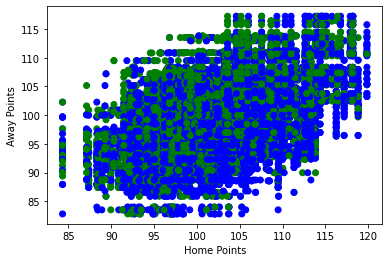

In [168]:
plt.scatter(X[:,11],X[:,23],c=colors)
plt.xlabel("Home Points")
plt.ylabel("Away Points")
